In [ ]:
%pip install torch torchvision torchaudio
%pip install pennylane
%pip install matplotlib
%pip install torchviz
%pip install qiskit

In [ ]:
!pip install PennyLane-SF

In [ ]:
! ls
! mkdir data
! unzip /content/data.zip -d data

In [ ]:
import time
import os
import copy

# tensorflow
import tensorflow as tf

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 30             # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)
# dev2 = qml.device("qiskit.aer", wires=n_qubits)

dev

<DefaultQubit device (wires=4, shots=None) at 0x7f86be85a2e0>

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "/content/data/data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1 )
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

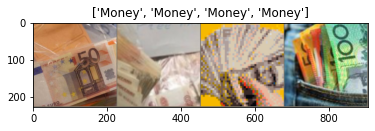

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]

    return tuple(exp_vals)

In [ ]:
# params = q_input_features
drawer = qml.draw(quantum_net(q_input_features, q_weights_flat), show_all_wires=True, wire_order=[0, 1, 2, 3])
print(drawer())

NameError: ignored

In [ ]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        print(f"This is output of resnet18: {pre_out}")
        q_in = torch.tanh(pre_out) * np.pi / 2.0
        print(f"this is Q INT: {q_in}")

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            # print(f"The output of q out element: {q_out_elem}")

            q_out = torch.cat((q_out, q_out_elem))
            # print(f"The outuput of q out: {q_out}")

        # circuit visualisation

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [ ]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)
model_hybrid

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [ ]:
# plotting params
loss_list = []  #list of loss for 30 epoch
acc_list = []   #list of acc for 30 epoch
running_lost_list = []
epoch_loss_list = []
running_corrects_list = []

another_loss_list = []
another_acc_list = []

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number


    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_

                epoch_loss = running_loss / len(dataloaders['train'])
                epoch_loss_list.append(epoch_loss)

                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]


            loss_list.append(epoch_loss)
            another_loss_list.append(epoch_loss)

            acc_list.append(epoch_acc)
            another_acc_list.append(epoch_acc)


            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

In [ ]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

In [ ]:
loss_list_copy = loss_list.copy()
acc_list_copy = acc_list.copy()
running_lost_list_copy = running_lost_list.copy()
epoch_loss_list_copy = epoch_loss_list.copy()
running_corrects_list_copy = running_corrects_list.copy()

In [ ]:
print(f"The Loss List copy is: {loss_list_copy}")
print(len(loss_list_copy))
print(f"Accuracy List Copy is: {acc_list_copy}")
print(len(acc_list_copy))
print(f"Running Loss List is: {running_lost_list_copy}")
print(f"Epoch Loss List is: {epoch_loss_list_copy}")
print(f"Running corrects List copy is: {running_corrects_list_copy}")

The Loss List copy is: [0.5818153213246078, 0.43614141059361294, 0.4336181197847639, 0.31758488625425346, 0.3666636237900378, 0.26057367102341716, 0.310665287592444, 0.20057241865841474, 0.29701886178436365, 0.16216904446826003, 0.23851510676370788, 0.13433119280409703, 0.1999243076221185, 0.12237524381980369, 0.2108629166667912, 0.09857250477105792, 0.22526066753721458, 0.08485906359992819, 0.21194669120185386, 0.08372663112554682, 0.25493608318990274, 0.07971886026969154, 0.21594622992150794, 0.07499845262428033, 0.16901140028293232, 0.07634779350823521, 0.19488036594769922, 0.08224957917005785, 0.19043661636828277, 0.07238415158289369, 0.14845656692844383, 0.07989810434629291, 0.16094544646652065, 0.07257462672305547, 0.17406941098826273, 0.06761116901850371, 0.16215226212130165, 0.07275689825896293, 0.22946981967250873, 0.06828692654997523, 0.17795076483886363, 0.07130374622097763, 0.1378788151499313, 0.06871351266648912, 0.16455549382806373, 0.0747253499959471, 0.1509297859902206,

In [ ]:
loss_list_copy2 = loss_list.copy()
acc_list_copy2 = acc_list.copy()
running_lost_list_copy2 = running_lost_list.copy()
epoch_loss_list_copy2 = epoch_loss_list.copy()
running_corrects_list_copy2 = running_corrects_list.copy()

In [ ]:
# backup
backup_loss_list = [0.5818153213246078, 0.43614141059361294, 0.4336181197847639, 0.31758488625425346, 0.3666636237900378, 0.26057367102341716, 0.310665287592444, 0.20057241865841474, 0.29701886178436365, 0.16216904446826003, 0.23851510676370788, 0.13433119280409703, 0.1999243076221185, 0.12237524381980369, 0.2108629166667912, 0.09857250477105792, 0.22526066753721458, 0.08485906359992819, 0.21194669120185386, 0.08372663112554682, 0.25493608318990274, 0.07971886026969154, 0.21594622992150794, 0.07499845262428033, 0.16901140028293232, 0.07634779350823521, 0.19488036594769922, 0.08224957917005785, 0.19043661636828277, 0.07238415158289369, 0.14845656692844383, 0.07989810434629291, 0.16094544646652065, 0.07257462672305547, 0.17406941098826273, 0.06761116901850371, 0.16215226212130165, 0.07275689825896293, 0.22946981967250873, 0.06828692654997523, 0.17795076483886363, 0.07130374622097763, 0.1378788151499313, 0.06871351266648912, 0.16455549382806373, 0.0747253499959471, 0.1509297859902206, 0.07039664266845598, 0.15227414070186526, 0.06960924405793441, 0.17788989749234943, 0.06864404427703075, 0.18063798708163098, 0.06886096149339654, 0.18113880062020868, 0.08460331018069922, 0.18757322883825697, 0.06426023681592281, 0.21416089848576603, 0.07138725555574839]

backup_acc_list = [0.7419354838709677, 0.7903225806451613, 0.8410138248847926, 0.9493087557603687, 0.8963133640552995, 0.9585253456221198, 0.9285714285714286, 0.9861751152073732, 0.8940092165898618, 0.9792626728110599, 0.9400921658986175, 0.9838709677419355, 0.9470046082949308, 0.9815668202764977, 0.9377880184331797, 0.9907834101382489, 0.923963133640553, 0.9976958525345622, 0.9216589861751152, 1.0, 0.9078341013824884, 0.9953917050691244, 0.9308755760368663, 1.0, 0.9539170506912442, 0.9953917050691244, 0.9354838709677419, 0.9930875576036866, 0.9377880184331797, 0.9976958525345622, 0.9585253456221198, 0.9907834101382489, 0.9470046082949308, 0.9976958525345622, 0.9447004608294931, 1.0, 0.9516129032258065, 1.0, 0.9193548387096774, 0.9953917050691244, 0.9447004608294931, 0.9907834101382489, 0.9608294930875576, 1.0, 0.9493087557603687, 0.988479262672811, 0.9493087557603687, 0.9953917050691244, 0.9423963133640553, 1.0, 0.9423963133640553, 0.9976958525345622, 0.9400921658986175, 1.0, 0.9470046082949308, 0.9861751152073732, 0.9308755760368663, 1.0, 0.9331797235023042, 1.0]

# backup_epoch_loss_list =


In [ ]:
loss_list3 = backup_loss_list.copy()
acc_list3 = backup_acc_list.copy()

In [ ]:
# removing odd elements of the list as it has elements of both train and validation
def remove_odd_elements(lst):
    lst = [v for i, v in enumerate(lst) if i % 2 == 0]

# remove_odd_elements(loss_list)
print(len(loss_list))

val_loss_list = []
train_loss_list = []
for i in range(0, len(loss_list)):
    if i % 2:
        train_loss_list.append(loss_list[i])
    else :
        val_loss_list.append(loss_list[i])



60


In [ ]:
print(len(val_loss_list))

30


30


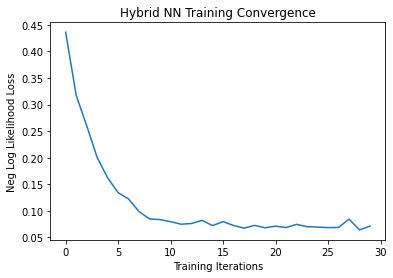

In [ ]:
# plotting the epoch loss graph

plt.plot(train_loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

print(len(train_loss_list))

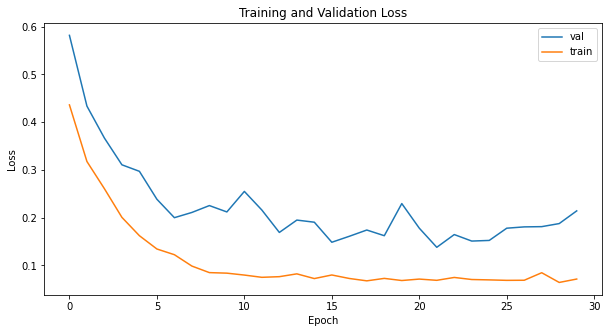

In [ ]:
# plotting the model loss graph

val_loss = []
train_loss = []
for i in range(0, len(loss_list_copy2)):
    if i % 2:
        train_loss.append(loss_list_copy2[i])
    else :
        val_loss.append(loss_list_copy2[i])

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_loss,label="val")
plt.plot(train_loss,label="train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


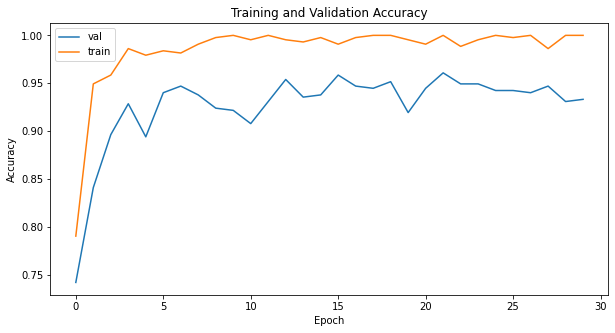

In [ ]:
# plotting the model accuracy graph
val_loss = []
train_loss = []
for i in range(0, len(acc_list_copy2)):
    if i % 2:
        train_loss.append(acc_list_copy2[i])
    else :
        val_loss.append(acc_list_copy2[i])

plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_loss,label="val")
plt.plot(train_loss,label="train")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            global NewOutput
            NewOutput = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

In [ ]:
NewOutput

tensor([[ 1.2454, -1.0926],
        [ 0.9515, -0.3731],
        [-1.1966,  1.9334],
        [-1.1974,  1.9327]])

In [ ]:

visualize_model(model_hybrid, num_images=batch_size)
plt.show()

NameError: ignored

In [ ]:
dummy_model_hybrid = model_hybrid
dummy_model_hybrid



In [ ]:
""" ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): DressedQuantumNet(
    (pre_net): Linear(in_features=512, out_features=4, bias=True)
    (post_net): Linear(in_features=4, out_features=2, bias=True)
  )
)
"""

In [ ]:
from torchviz import make_dot

def visualize_model_again(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            global NewInputs
            NewInputs = inputs
            labels = labels.to(device)
            outputs = model(inputs)


            global NewOutputVar
            NewOutputVar = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return